In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier, Pool

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, KFold

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
from collections import Counter

def get_mode(row): # Кастомная функция вычисления модального значения категориального признака
    counter = Counter(row)
    (most_common, _) = counter.most_common(1)[0]

    return most_common

In [7]:
def validation(model, X_valid, y_valid):
    if model == catc:
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
    #расчет метрики
    print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))
    print("accuracy: ", accuracy_score(y_valid, model_valid))
    print("Отчет о классификации: ")
    print(classification_report(y_valid, model_valid))
    #матрица ошибок
    print("Матрица ошибок: ")
    cm = confusion_matrix(y_valid, model_valid)#, normalize='true'
    cm_display = ConfusionMatrixDisplay(cm).plot(colorbar=False, cmap="GnBu")

    fig, ax = plt.subplots(figsize=(8, 6))
    if model == catc:
        #влияющие факторы
        fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_valid.columns})
        fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
        ax.barh(fea_imp['col'], fea_imp['imp'], align='center')

    plt.title('Важность признаков для модели')
    plt.ylabel('Признаки')
    plt.xlabel('Важность')

## Загрузка тренировочных данных

In [198]:
df_train = pd.read_csv('train_data/cntrbtrs_clnts_ops_trn.csv', encoding='cp1251', sep=";", low_memory=False)
df_train.head(2)

,slctn_nmbr,clnt_id,accnt_id,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,...,dstrct,city,sttlmnt,pstl_code,okato,phn,email,lk,assgn_npo,assgn_ops
0,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,NaN,ОМСК Г,NaN,644001,5.200000e+10,нет,нет,нет,нет,нет
1,0,0x15138C4A822F1C45A819FCBE6657B810,0x222F5E5BA3715F418662A3C65B0B051F,м,1954,70,2009-06-29,283,0,Накопительный период,...,NaN,БЕЛОГОРСК Г,NaN,676852,1.000000e+10,нет,нет,нет,нет,нет


Анализ целевой переменной

<Axes: xlabel='prsnt_age', ylabel='count'>

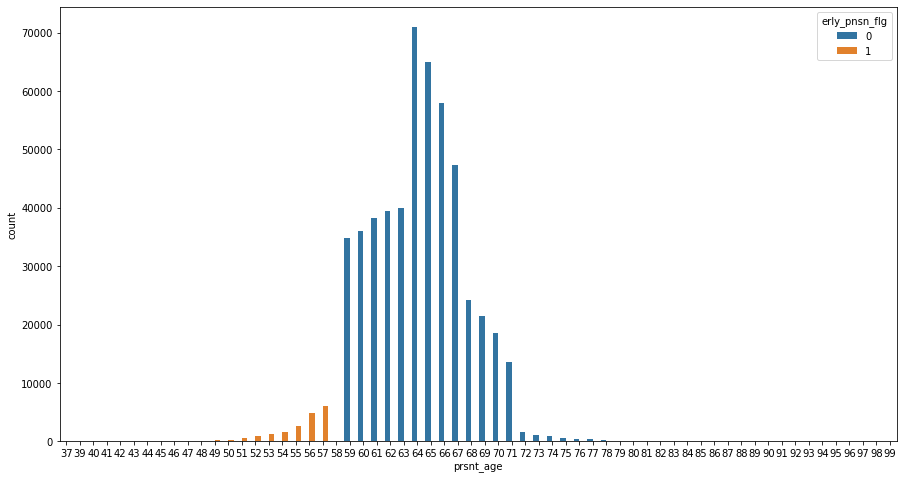

In [21]:
plt.figure(figsize=(15,8))
sns.countplot(x="prsnt_age", hue="erly_pnsn_flg", data = df_train)

In [199]:
# данные о транзакциях
df_train_ = pd.read_csv('train_data/trnsctns_ops_trn.csv', encoding='cp1251', sep=";")
df_train_.head()

,accnt_id,mvmnt_type,sum_type,cmmnt,sum,oprtn_date
0,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,2096.31,2012-02-12
1,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-02-13
2,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-05-15
3,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-08-14
4,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-11-13


In [200]:
trnsctns = df_train_.groupby('accnt_id', as_index=False).agg(
    counting=('mvmnt_type', 'count'),   #записей на человека
    mvmnt_type=('mvmnt_type', 'mean'),        #каких больше
    sum_type =('sum_type', get_mode),   #популярный тип
    cmmnt=('cmmnt', get_mode), #популярный тип
    sums=('sum', 'sum'), #обзщая сумма
    cmmnt_unique=('cmmnt', 'nunique'), #Вычисляем браузер/приложение пользователя
)
trnsctns.head(2)

,accnt_id,counting,mvmnt_type,sum_type,cmmnt,sums,cmmnt_unique
0,0x00003A37F46E104EB1AB513510DC1C79,28,0.000000,ИД на страховые взносы на НЧ,Распределение ИД ОПС,3352.96,2
1,0x00005C5B81A6B34C93DD254536771BB6,48,0.083333,Страховые взносы на НЧ,Поступление взносов ОПС,36472.74,5


In [202]:
#заполняем пропуски
df_train['rgn']=df_train['rgn'].fillna(df_train['rgn'].mode()[0])
df_train['okato']=df_train['okato'].fillna(df_train['okato'].mode()[0]).astype(int)

In [203]:
# полный датасет
cols = ['accnt_id', 'gndr', 'brth_yr', 'prsnt_age', 'cprtn_prd_d', 'erly_pnsn_flg', 'accnt_status',
       'pnsn_age', 'prvs_npf', 'rgn', 'phn', 'email', 'lk',
       'assgn_npo', 'assgn_ops']
merged_df = pd.merge(df_train[cols], trnsctns, on=['accnt_id'])

In [204]:
merged_df['gndr_age'] = merged_df['gndr'] + merged_df['prsnt_age'].astype(str)

Объединнеый датасет со всеми сгеренированными признаками

In [205]:
merged_df.head(2)

,accnt_id,gndr,brth_yr,prsnt_age,cprtn_prd_d,erly_pnsn_flg,accnt_status,pnsn_age,prvs_npf,rgn,...,lk,assgn_npo,assgn_ops,counting,mvmnt_type,sum_type,cmmnt,sums,cmmnt_unique,gndr_age
0,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,96,0,Накопительный период,55,СФР,ОМСКАЯ ОБЛ,...,нет,нет,нет,56,0.107143,ИД на страховые взносы на НЧ,Поступление взносов ОПС,25704.27,4,ж64
1,0x222F5E5BA3715F418662A3C65B0B051F,м,1954,70,283,0,Накопительный период,60,СФР,АМУРСКАЯ ОБЛ,...,нет,нет,нет,45,0.088889,Страховые взносы на НЧ,Поступление взносов ОПС,40708.20,5,м70


Убираем из  обучения возраст, по которому таргет только один класс

In [206]:
#58-67 есть и досрочные и недосрочные
temp = merged_df[(merged_df['prsnt_age']>=58)&(merged_df['prsnt_age']<=67)]

In [207]:
merged_df.columns

Index(['accnt_id', 'gndr', 'brth_yr', 'prsnt_age', 'cprtn_prd_d',
       'erly_pnsn_flg', 'accnt_status', 'pnsn_age', 'prvs_npf', 'rgn', 'phn',
       'email', 'lk', 'assgn_npo', 'assgn_ops', 'counting', 'mvmnt_type',
       'sum_type', 'cmmnt', 'sums', 'cmmnt_unique', 'gndr_age'],
      dtype='object')

Бейзлайн

In [47]:
#предварительно обработать accnt_bgn_date prvs_npf brth_plc dstrct city  sttlmnt  pstl_code 'addrss_type','okato', 
# cprtn_prd_d Время между датой заключения договора и датой статуса договора
#числовые колонки
num_col = ['pnsn_age', 'cprtn_prd_d', 'prsnt_age', 'brth_yr', 'counting', 'mvmnt_type',
          'sums', 'cmmnt_unique'] #'cprtn_prd_d', 'prsnt_age', 'brth_yr',
#категориальные колонки
cat_col = ['gndr',   'rgn', 'phn', 'email', 'lk', 'assgn_npo', 'assgn_ops', #'accnt_status',
          'gndr_age', 'sum_type', 'cmmnt']
#target-колонки
targets_col = ['slctn_nmbr', 'clnt_id', 'accnt_id', 'erly_pnsn_flg'] #, 'accnt_status'

#feat_col = ['prsnt_age', 'gndr', 'rgn']

feat_col = num_col + cat_col# + 'gndr_age'

In [48]:
cat_col_= [col for col in cat_col if col in feat_col]

In [164]:
temp['erly_pnsn_flg'].value_counts()

erly_pnsn_flg
0    429931
1       491
Name: count, dtype: int64

Уменьшаем размер класса 0, чтобы устранить большой дисбаланс классов

In [173]:
# выборка для каждого класса 491 досрочно
sample_train=pd.DataFrame()
for j in [0, 1]:
    try:
        temp_ = temp[temp['erly_pnsn_flg']==j].sample(n=100000, random_state=42)
    except:
        temp_ = temp[temp['erly_pnsn_flg']==j]
    sample_train = pd.concat([sample_train, temp_], ignore_index=True)

In [174]:
sample_train['erly_pnsn_flg'].value_counts(normalize=True)

erly_pnsn_flg
0    0.995114
1    0.004886
Name: proportion, dtype: float64

Разделение на тренировочную и валидационную выборки

In [175]:
ALL_IDS = sample_train['accnt_id'].unique()
#Делим на обучающую и валидационную выборки
TRAIN_IDS, VAL_IDS = train_test_split(ALL_IDS, train_size=0.8, shuffle=True, random_state=10)

In [176]:
HOLD_IDS = merged_df[(merged_df['prsnt_age']<58)|(merged_df['prsnt_age']>67)]['accnt_id'].unique()
hold_events = merged_df[merged_df['accnt_id'].isin(HOLD_IDS)]

In [177]:
train_events = merged_df[merged_df['accnt_id'].isin(TRAIN_IDS)] #группируем события для тех пользователей, которые есть в тренировочной выборке
val_events = merged_df[merged_df['accnt_id'].isin(VAL_IDS)]     #группируем события для тех пользователей, которые есть в валидационной выборке

In [179]:
#feat_col = num_col + cat_col
X_train_part = train_events[feat_col]
X_valid = val_events[feat_col]

In [180]:
#создаем датафреймы с целевым столбцом пола
y_train_part = train_events['erly_pnsn_flg']
y_valid = val_events['erly_pnsn_flg']

In [181]:
X_hold = hold_events[feat_col]
y_hold = hold_events['erly_pnsn_flg']

### Классификация CatBoost

In [182]:
#создаем предсказательную модель и обучаем её
catc = CatBoostClassifier(loss_function = "Logloss",
                          #eval_metric="F1",
                          eval_metric="AUC",
                          learning_rate=0.01,
                          max_depth = 16,
                          #l2_leaf_reg = 3.5,
                          n_estimators = 1000,
                          auto_class_weights='Balanced',
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=cat_col_,
         early_stopping_rounds = 50, use_best_model=True, verbose=500)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9981593	best: 0.9981593 (0)	total: 20.8ms	remaining: 20.8s
bestTest = 0.9996494651
bestIteration = 32
Shrink model to first 33 iterations.


f1_weight:  0.9964968093722149
accuracy:  0.9959201950345788
Отчет о классификации: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19996
           1       0.56      1.00      0.72       103

    accuracy                           1.00     20099
   macro avg       0.78      1.00      0.86     20099
weighted avg       1.00      1.00      1.00     20099

Матрица ошибок: 


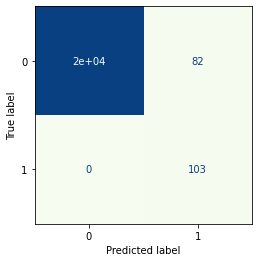

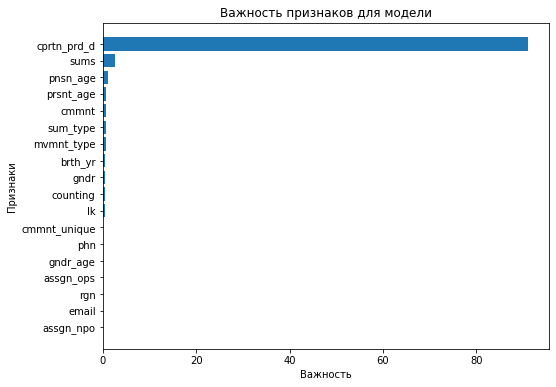

In [183]:
#запуск модели для валидационных данных
validation(catc, X_valid, y_valid)

Валилдация на отложенной выборке

f1_weight:  0.9729654914149837
accuracy:  0.9735456969034111
Отчет о классификации: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     83517
           1       0.98      0.88      0.92     18886

    accuracy                           0.97    102403
   macro avg       0.98      0.94      0.95    102403
weighted avg       0.97      0.97      0.97    102403

Матрица ошибок: 


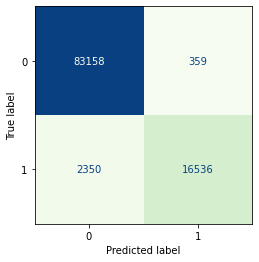

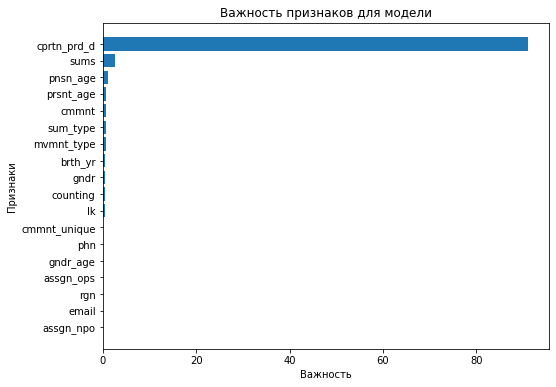

In [184]:
validation(catc, X_hold, y_hold)

In [185]:
#для предскзания
#model_pred = catc.predict(X_test[feat_col])

### Предсказание как выяаление аномалий

In [86]:
# fit the model
clf = IsolationForest(max_samples=50000, random_state=42)
clf.fit(X_train_part[num_col])
y_pred_outliers = clf.predict(X_train_part[num_col])
y_pred_outliers = np.where(y_pred_outliers == 1, 0, 1)

In [87]:
print("f1_weight: ", f1_score(y_train_part, y_pred_outliers, average='weighted'))

f1_weight:  0.9761023859076617


In [88]:
y_pred_outliers = clf.predict(X_valid[num_col])
y_pred_outliers = np.where(y_pred_outliers == 1, 0, 1)

In [89]:
print("f1_weight: ", f1_score(y_valid, y_pred_outliers, average='weighted'))

f1_weight:  0.9744320429833244


In [90]:
print(classification_report(y_valid, y_pred_outliers))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19996
           1       0.11      1.00      0.20       103

    accuracy                           0.96     20099
   macro avg       0.55      0.98      0.59     20099
weighted avg       1.00      0.96      0.97     20099



### Предсказание логистической регрессией

In [188]:
logit = LogisticRegression(random_state=42, solver='lbfgs', C = 1.0, max_iter=100)

In [189]:
logit.fit(X_train_part[num_col], y_train_part)

LogisticRegression(random_state=42)

In [190]:
y_pred = logit.predict(X_valid[num_col])

In [191]:
print("f1_weight: ", f1_score(y_valid, y_pred, average='weighted'))

f1_weight:  0.9958311269393152


In [192]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19996
           1       0.68      0.48      0.56       103

    accuracy                           1.00     20099
   macro avg       0.84      0.74      0.78     20099
weighted avg       1.00      1.00      1.00     20099



In [194]:
#logit_pred = logit.predict(X_test[num_col])

#### По фолдам

In [105]:
train_df_part = merged_df[(merged_df['prsnt_age']>=58)&(merged_df['prsnt_age']<=67)]#['accnt_id'].unique()

In [109]:
catc = CatBoostClassifier(loss_function = "Logloss",
                          eval_metric="F1",
                          #eval_metric="AUC",
                          learning_rate=0.01,
                          max_depth = 16,
                          #l2_leaf_reg = 3.5,
                          n_estimators = 1000,
                          auto_class_weights='Balanced',
                          leaf_estimation_iterations=1, random_state=42, task_type='GPU')

### Загрузка тестовых данных

In [208]:
df_test = pd.read_csv('test_data/cntrbtrs_clnts_ops_tst.csv', encoding='cp1251', sep=";")
df_test.head(2)

,slctn_nmbr,clnt_id,accnt_id,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,accnt_status,pnsn_age,...,dstrct,city,sttlmnt,pstl_code,okato,phn,email,lk,assgn_npo,assgn_ops
0,0,0x974BA5AD563F3B4BA6573C9C32CC9886,0x828738D13E70E44D9A97F595ADBC4A33,ж,1960,64,2005-12-16,101,Накопительный период,55,...,NaN,ВОРОНЕЖ Г,NaN,394010,2.000000e+10,нет,нет,нет,нет,нет
1,0,0x847B12D73A12B542BB738100FB707B65,0xA4F3243B96C17B4B93C3663D72B69908,ж,1962,62,2013-08-24,611,Накопительный период,55,...,NaN,КОПЕЙСК Г,NaN,456617,7.500000e+10,нет,нет,нет,нет,нет


In [209]:
df_test_ = pd.read_csv('test_data/trnsctns_ops_tst.csv', encoding='cp1251', sep=";")
df_test_.head(2)

,accnt_id,mvmnt_type,sum_type,cmmnt,sum,oprtn_date
0,0x000102D7080E8745A76B4A97BEEA8568,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,1285.36,2010-02-22
1,0x000102D7080E8745A76B4A97BEEA8568,0.0,ИД на страховые взносы на НЧ,Распределение ИД ОПС,96.02,2010-11-16


In [210]:
#для сабмита
submit = df_test[['accnt_id']].copy()

In [211]:
trnsctns_ = df_test_.groupby('accnt_id', as_index=False).agg(
    counting=('mvmnt_type', 'count'),   #записей на человека
    mvmnt_type=('mvmnt_type', 'mean'),        #каких больше
    sum_type =('sum_type', get_mode),   #популярный тип
    cmmnt=('cmmnt', get_mode), #популярный тип
    sums=('sum', 'sum'), #обзщая сумма
    cmmnt_unique=('cmmnt', 'nunique'), #Вычисляем браузер/приложение пользователя
)
trnsctns_.head(2)

,accnt_id,counting,mvmnt_type,sum_type,cmmnt,sums,cmmnt_unique
0,0x000102D7080E8745A76B4A97BEEA8568,39,0.0,ИД на страховые взносы на НЧ,Поступление взносов ОПС,1883.72,4
1,0x0001A43910E96F4597865F45489E2A9D,15,0.0,ИД на страховые взносы на НЧ,Распределение ИД ОПС,2780.27,3


In [212]:
#заполняем пропуски
df_test['rgn']=df_test['rgn'].fillna(df_test['rgn'].mode()[0])
df_test['okato']=df_test['okato'].fillna(df_test['okato'].mode()[0]).astype(int)

In [213]:
# полный датасет
cols_ = ['accnt_id', 'gndr', 'brth_yr', 'prsnt_age', 'cprtn_prd_d', 'accnt_status',
       'pnsn_age', 'prvs_npf', 'rgn', 'phn', 'email', 'lk',
       'assgn_npo', 'assgn_ops']
merged_df_ = pd.merge(df_test[cols_], trnsctns_, on=['accnt_id'])

In [214]:
merged_df_.head(2)

,accnt_id,gndr,brth_yr,prsnt_age,cprtn_prd_d,accnt_status,pnsn_age,prvs_npf,rgn,phn,email,lk,assgn_npo,assgn_ops,counting,mvmnt_type,sum_type,cmmnt,sums,cmmnt_unique
0,0x828738D13E70E44D9A97F595ADBC4A33,ж,1960,64,101,Накопительный период,55,СФР,ВОРОНЕЖСКАЯ ОБЛ,нет,нет,нет,нет,нет,54,0.074074,ИД на страховые взносы на НЧ,Поступление взносов ОПС,2255.33,4
1,0xA4F3243B96C17B4B93C3663D72B69908,ж,1962,62,611,Накопительный период,55,СФР,ЧЕЛЯБИНСКАЯ ОБЛ,нет,нет,нет,нет,нет,15,0.000000,ИД на страховые взносы на НЧ,Распределение ИД ОПС,1137.70,4


In [215]:
merged_df_['gndr_age'] = merged_df_['gndr'] + merged_df_['prsnt_age'].astype(str)

In [217]:
X_test = merged_df_[feat_col]
X_test.head(2)

,pnsn_age,cprtn_prd_d,prsnt_age,brth_yr,counting,mvmnt_type,sums,cmmnt_unique,gndr,rgn,phn,email,lk,assgn_npo,assgn_ops,gndr_age,sum_type,cmmnt
0,55,101,64,1960,54,0.074074,2255.33,4,ж,ВОРОНЕЖСКАЯ ОБЛ,нет,нет,нет,нет,нет,ж64,ИД на страховые взносы на НЧ,Поступление взносов ОПС
1,55,611,62,1962,15,0.000000,1137.70,4,ж,ЧЕЛЯБИНСКАЯ ОБЛ,нет,нет,нет,нет,нет,ж62,ИД на страховые взносы на НЧ,Распределение ИД ОПС


In [156]:
num_folds = 5

folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)

predictions = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df_part)):
    print("fold n°{}".format(fold_ + 1))
    X_trn = train_df_part[feat_col].iloc[trn_idx]
    y_trn = train_df_part['erly_pnsn_flg'].iloc[trn_idx]
    X_val = train_df_part[feat_col].iloc[val_idx]
    y_val = train_df_part['erly_pnsn_flg'].iloc[val_idx]

    clf = catc.fit(X_trn, y_trn, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds = 50, 
                  use_best_model=True, cat_features=cat_col_)
    
    predictions += clf.predict(X_test[feat_col], prediction_type='Probability')[:, 1] / folds.n_splits

fold n°1
0:	learn: 0.9990444	test: 0.9555079	best: 0.9555079 (0)	total: 491ms	remaining: 8m 10s
bestTest = 0.993289197
bestIteration = 4
Shrink model to first 5 iterations.
fold n°2
0:	learn: 0.9984078	test: 0.9793884	best: 0.9793884 (0)	total: 481ms	remaining: 8m
bestTest = 0.9846229033
bestIteration = 12
Shrink model to first 13 iterations.
fold n°3
0:	learn: 0.9991750	test: 0.9389679	best: 0.9389679 (0)	total: 490ms	remaining: 8m 9s
100:	learn: 0.9989370	test: 0.9831198	best: 0.9883862 (95)	total: 30.2s	remaining: 4m 28s
bestTest = 0.9883862345
bestIteration = 95
Shrink model to first 96 iterations.
fold n°4
0:	learn: 0.9954503	test: 0.9956424	best: 0.9956424 (0)	total: 33ms	remaining: 33s
100:	learn: 0.9988413	test: 0.9989949	best: 0.9989949 (100)	total: 33.3s	remaining: 4m 56s
200:	learn: 0.9992200	test: 0.9992843	best: 0.9992843 (197)	total: 1m 15s	remaining: 4m 58s
300:	learn: 0.9994857	test: 0.9995057	best: 0.9995114 (296)	total: 2m 3s	remaining: 4m 46s
400:	learn: 0.9995815	te

In [218]:
y_pred = np.where(predictions <0.5, 0, 1)
submit['erly_pnsn_flg']=y_pred
submit.head(2)

,accnt_id,erly_pnsn_flg
0,0x828738D13E70E44D9A97F595ADBC4A33,0
1,0xA4F3243B96C17B4B93C3663D72B69908,0


Сохранение сабмита

In [171]:
submit[['accnt_id', 'erly_pnsn_flg']].to_csv('submission2.csv', index=False)

In [186]:
#submit['erly_pnsn_flg']=model_pred
#submit[['accnt_id', 'erly_pnsn_flg']].to_csv('submission3.csv', index=False)

In [195]:
#submit['erly_pnsn_flg']=logit_pred
#submit[['accnt_id', 'erly_pnsn_flg']].to_csv('submission4.csv', index=False)